In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

In [2]:
def add_prior_features(df, hour_max):
    one_hour_in_seconds = 3600
    for i in range(1,hour_max):
        df[f'dt_est_minus_{i}hr'] = df['dt_est'] - i*one_hour_in_seconds
    
        watertemp = df[['dt_est', 'v']]
        watertemp.columns = [f'{c}_minus_{i}hr' for c in watertemp.columns]
    
        airtemp = df[['dt_est', 'temp']]
        airtemp.columns = [f'{c}_minus_{i}hr' for c in airtemp.columns]
        
        df = pd.merge(df, airtemp, on=f'dt_est_minus_{i}hr', how='inner')
        df = pd.merge(df, watertemp, on=f'dt_est_minus_{i}hr', how='inner')

    return df


'''
This is for simulating a live predictive forecaster that uses the prior hour's temperature as a feature. In live use, if we want to
predict the next 7 days of water temperature, the model won't know the prior hour's temperature at any given point in the future, since
it hasn't happened yet. So we need to make stepwise predictions and set the next point's "v_minus_1hr" as the current point's prediction
value.

*Requires a model that uses "v_minus_1hr" as a feature
'''
def predict_stepwise(X_test, model):
    # Initialize an empty list to store predictions
    stepwise_preds = []
    
    # Iterate through X_test by its index, except the last row for which there is no "next point"
    for position in range(len(X_test) - 1):
        # Select current point
        current_point = X_test.iloc[[position]]
        
        # Predict on current_point and store the prediction
        current_pred = model.predict(current_point)
        stepwise_preds.append(current_pred.item())  # Assuming model.predict returns an array, use .item() to get the value
        
        # Update 'v_minus_1hr' for the next point
        next_position = position + 1
        X_test.iloc[next_position, X_test.columns.get_loc('v_minus_1hr')] = current_pred
    
    # Handle prediction for the last row separately if needed
    last_point = X_test.iloc[[-1]]
    last_pred = model.predict(last_point)
    stepwise_preds.append(last_pred.item())
    
    return stepwise_preds

In [3]:
def get_dataframe():
    label = pd.read_csv('water_temp_dc_2016_2024_hourly.csv')[['t', 'v']]
    weather = pd.read_csv('cln_dc_weather_2016_2024_hourly.csv')    
    label['t'] = pd.to_datetime(label['t'])
    label['dt_est'] = label['t'].astype('int64') // 1e9
    df = pd.merge(label, weather, on='dt_est', how='inner')
    df.index = df['t']
    
    return df


def preprocess(df, features=None):
    df = df[df['v'].notna()]
    if features:
        for f in features:
            df = df[df[f].notna()]
    
    return df


def split_train_test(df):
    train_df = df.loc[df.index < '2023-01-01 00:00:00']
    test_df = df.loc[df.index >= '2023-01-01 00:00:00']

    return train_df, test_df


def split_features_target(train_df, test_df, FEATURES, TARGET):
    X_train = train_df[FEATURES]
    y_train = train_df[TARGET]
    
    X_test = test_df[FEATURES]
    y_test = test_df[TARGET]

    return X_train, y_train, X_test, y_test

In [4]:
df = get_dataframe()
df = preprocess(df)

train_df, test_df = split_train_test(df)

FEATURES = ['month', 'hour', 'day']
TARGET = 'v'

X_train, y_train, X_test, y_test = split_features_target(train_df, test_df, FEATURES, TARGET)

model = xgb.XGBRegressor()
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])

KeyError: "None of [Index(['month', 'hour', 'day'], dtype='object')] are in the [columns]"

In [ ]:
# Scatter plot for training data in one color, e.g., blue
plt.scatter(train_df.index, train_df['v'], label='Train Data', color='blue', s=1) # s is the size of the marker

# Scatter plot for testing data in another color, e.g., red
plt.scatter(test_df.index, test_df['v'], label='Test Data', color='red', s=1) # s is the size of the marker

# Adding labels and title for clarity
plt.xlabel('Time')
plt.ylabel('v')
plt.title('Train vs Test Data Scatter Plot')
plt.legend()

# Show plot
plt.show()


In [ ]:
# Step 1: Generate Predictions
y_pred = model.predict(X_test)

plt.scatter(test_df.index, y_pred, label='Validation Data', color='blue', s=1)

# Scatter plot for testing data in another color, e.g., red
plt.scatter(test_df.index, test_df['v'], label='Test Data', color='red', s=1) # s is the size of the marker

# Adding labels and title for clarity
plt.xlabel('Time')
plt.ylabel('v')
plt.title('Validation vs Test Data Scatter Plot')
plt.legend()

# Show plot
plt.show()


In [ ]:
# Step 2: Plot True vs. Predicted Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='red')  # Plotting test vs. predictions
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line for reference
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs. Predicted Values')

# Optionally, add a trend line (commented out)
# z = np.polyfit(y_test, y_pred, 1)
# p = np.poly1d(z)
# plt.plot(y_test,p(y_test),"r--")

plt.show()

In [5]:
df = get_dataframe()
df = preprocess(df)

df['month'] = df.index.month
df['hour'] = df.index.hour
df['day'] = df.index.day

train_df, test_df = split_train_test(df)

FEATURES = ['month', 'hour', 'day']
TARGET = 'v'

X_train, y_train, X_test, y_test = split_features_target(train_df, test_df, FEATURES, TARGET)

model = xgb.XGBRegressor()
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])

[0]	validation_0-rmse:11.69051	validation_1-rmse:10.59892
[1]	validation_0-rmse:8.49115	validation_1-rmse:7.38976
[2]	validation_0-rmse:6.35597	validation_1-rmse:5.28291
[3]	validation_0-rmse:4.98422	validation_1-rmse:3.97055
[4]	validation_0-rmse:4.14603	validation_1-rmse:3.27793
[5]	validation_0-rmse:3.64799	validation_1-rmse:2.93834
[6]	validation_0-rmse:3.38115	validation_1-rmse:2.82075
[7]	validation_0-rmse:3.23275	validation_1-rmse:2.80588
[8]	validation_0-rmse:3.15421	validation_1-rmse:2.83014
[9]	validation_0-rmse:3.11086	validation_1-rmse:2.86180
[10]	validation_0-rmse:3.08582	validation_1-rmse:2.87344
[11]	validation_0-rmse:3.07158	validation_1-rmse:2.88834
[12]	validation_0-rmse:3.06427	validation_1-rmse:2.90515
[13]	validation_0-rmse:3.06044	validation_1-rmse:2.91896
[14]	validation_0-rmse:3.05812	validation_1-rmse:2.92726
[15]	validation_0-rmse:3.05553	validation_1-rmse:2.93263
[16]	validation_0-rmse:3.05454	validation_1-rmse:2.93746
[17]	validation_0-rmse:3.05288	validati

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

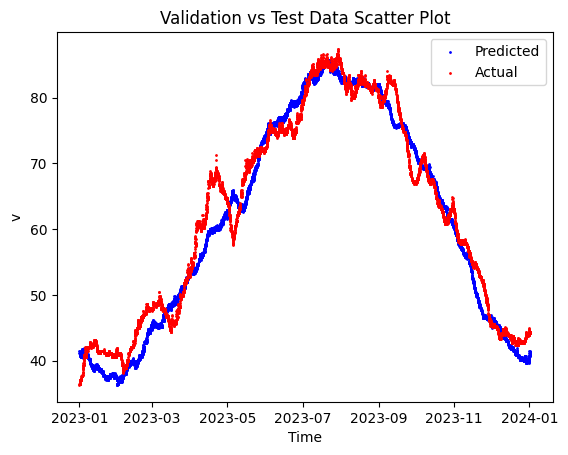

In [6]:
# Step 1: Generate Predictions
y_pred = model.predict(X_test)

plt.scatter(test_df.index, y_pred, label='Predicted', color='blue', s=1)

# Scatter plot for testing data in another color, e.g., red
plt.scatter(test_df.index, test_df['v'], label='Actual', color='red', s=1) # s is the size of the marker

# Adding labels and title for clarity
plt.xlabel('Time')
plt.ylabel('v')
plt.title('Validation vs Test Data Scatter Plot')
plt.legend()

# Show plot
plt.show()